# Arkhamdb Investigator Popularity Racing Bar Chart
Created: 2021-11-02  
Updated: 2022-02-25  
Author: Spencer Simon

## Overview

This notebook uses data downloaded from [arkhamdb.com](https://arkhamdb.com) using their [public api](https://arkhamdb.com/api/).  The data downloading and cleaning is performed in the arkhamdb-data repository. 

This data is transformed and used to create a racing bar chart of investigator popularity over time in this notebook.  

## Setup

### Install and import libraries

In [1]:
#import sys
#!{sys.executable} -m pip install git+https://github.com/programiz/bar_chart_race.git@master --user
#!{sys.executable} -m pip install openpyxl --user

In [2]:
import pandas as pd
from datetime import datetime
#import bar_chart_race as bcr
import matplotlib.pyplot as plt
import numpy as np
import pandasql
import datetime as dt
import time
import re

In [3]:
pd.set_option('display.max_columns', 50)

In [4]:
timestr = time.strftime("%Y-%m-%d")

### Load Data

In [5]:
filestr_cln = 'decklists_clean_'+timestr+'.csv'
pathstr_cln = '../arkhamdb-data/'+filestr_cln
#df = pd.read_csv(pathstr_cln)
df = pd.read_csv('../arkhamdb-data/decklists_clean_2022-02-24.csv')

In [6]:
#df.head()

In [7]:
df.shape

(20985, 23)

## Data Preparation

### Datetime conversion

In [8]:
df[['date_creation','date_update']] = df[['date_creation','date_update']].apply(pd.to_datetime)

### Drop duplicate decks 

In [9]:
# Initial step: Already done in arkhamdb-data but double check
df_drop0 = df.drop_duplicates(
    subset = ['name', 'date_creation'],
    keep = 'first').reset_index(drop = True)

In [10]:
df_drop0.shape

(20985, 23)

In [11]:
# Drop multiple decks with same user and name on same day as duplicates as well, 
# in addition to just same time. Keep the first.
df_drop1 = df_drop0.drop_duplicates(
    subset = ['name', 'user_id', 'investigator_code', 'create_year','create_month','create_day'],
    keep = 'first').reset_index(drop = True)

In [12]:
df_drop1.shape

(19825, 23)

In [13]:
# Using SQL window function: grouping by user and investigator ID, calculate the number of days
# since the last deck that user built of that investigator

data = pandasql.sqldf("""
SELECT 
    id, name, date_creation, 
    julianday(date_creation) - lag(julianday(date_creation)) 
        over (PARTITION BY user_id, investigator_code
              ORDER BY date_creation
        ) as creation_diff,
    date_update, description_md, user_id, investigator_code, investigator_name,
    version, previous_deck, next_deck, create_year, create_month, create_day
FROM
    df_drop1
ORDER BY
    user_id, investigator_code, date_creation
;""", globals())

In [14]:
data.head()

,id,name,date_creation,creation_diff,date_update,description_md,user_id,investigator_code,investigator_name,version,previous_deck,next_deck,create_year,create_month,create_day
0,1,Roland Banks Starter Deck,2016-09-02 13:17:02.000000,NaN,2022-01-15 19:13:07.000000,Roland Banks suggested deck from the Core Set\...,3,1001,Roland Banks,1,NaN,NaN,2016,9,2
1,2,Wendy Adams Starter Deck,2016-09-02 13:18:34.000000,NaN,2022-02-10 17:12:27.000000,Wendy Adams starter deck from the core set.,3,1005,Wendy Adams,1,NaN,NaN,2016,9,2
2,186,For the Want of a Machete,2016-12-06 04:12:24.000000,NaN,2016-12-07 16:40:30.000000,My list is still evolving but here's where I'm...,13,1001,Roland Banks,1,NaN,NaN,2016,12,6
3,284,Cutting Corners (Post-Dunwich Roland),2017-01-14 20:01:32.000000,39.65912,2017-01-17 01:46:08.000000,"<b>Cutting Corners</b>\r\n\r\nThis is a ""post-...",13,1001,Roland Banks,2,NaN,NaN,2017,1,14
4,847,Backup Has Arrived (Charisma Build for Roland),2017-03-26 23:17:31.000000,71.13610,2017-03-26 23:17:31.000000,<h4>Roland Banks: Backup Has Arrived</h4>\r\n\...,13,1001,Roland Banks,1,NaN,NaN,2017,3,26


In [15]:
data.shape

(19825, 15)

In [16]:
# Drop decks with same name, user, and investigator within 60 days
drop2 = data[(~((data.duplicated(subset=['name', 'user_id', 'investigator_code'], # decks w/ same name, user, inv
                    keep='first')) &         # Keep only 1 of each group of duplicate decks
   (data.creation_diff <= 60)))]              # Drop if created within 60 days of previous deck by same name

In [17]:
drop2.shape

(17642, 15)

In [18]:
# Drop decks with:
#   - same user and investigator AND
#   - within 30 days since last deck of this inv. by this user AND
#   - (name contains "upgraded") OR (name or descr. contains "update")
drop3 = drop2[(~((drop2.duplicated(subset=['user_id', 'investigator_code'], # decks w/ same user and inv
                                   keep='first')) &         # Keep only 1 of each group of duplicate decks
                 (drop2.creation_diff <= 30) &       # decks within 30 days since last deck w/ same user & inv
                 
                 # Decks w/ "upgraded" in the name or "update" in the name or descr:
                 ((drop2.name.str.contains('.*update.*',flags=re.IGNORECASE, regex=True)) |
                  (drop2.description_md.str.contains('.*update.*',flags=re.IGNORECASE, na=False,regex=True)) |
                  (drop2.name.str.contains('.*upgraded.*',flags=re.IGNORECASE, regex=True)))
                )
              )]

In [19]:
drop3.shape

(17525, 15)

In [20]:
# Drop decks with same user & inv., where version > 1 and within 25 days
drop4 = drop3[(~((drop3.duplicated(subset=['user_id', 'investigator_code'], # decks w/ same user and inv
                                   keep='first')) &         # Keep only 1 of each group of duplicate decks
                 (drop3.version > 1) &
                 (drop3.creation_diff <= 25))
              )]

In [21]:
drop4.shape

(16886, 15)

In [22]:
print(f"Number of duplicate decks dropped: {df.shape[0] - drop4.shape[0]}")

Number of duplicate decks dropped: 4099


In [23]:
df_clean = drop4.copy()

### Create date only field (without time), and date2 with only year-month

In [24]:
df_clean['date'] = pd.to_datetime(df_clean['date_creation']).dt.date

In [25]:
df_clean['date2'] = pd.to_datetime(df_clean['date_creation']).dt.date.apply(lambda x: x.strftime('%Y-%m'))

In [26]:
df_clean.head()

,id,name,date_creation,creation_diff,date_update,description_md,user_id,investigator_code,investigator_name,version,previous_deck,next_deck,create_year,create_month,create_day,date,date2
0,1,Roland Banks Starter Deck,2016-09-02 13:17:02.000000,NaN,2022-01-15 19:13:07.000000,Roland Banks suggested deck from the Core Set\...,3,1001,Roland Banks,1,NaN,NaN,2016,9,2,2016-09-02,2016-09
1,2,Wendy Adams Starter Deck,2016-09-02 13:18:34.000000,NaN,2022-02-10 17:12:27.000000,Wendy Adams starter deck from the core set.,3,1005,Wendy Adams,1,NaN,NaN,2016,9,2,2016-09-02,2016-09
2,186,For the Want of a Machete,2016-12-06 04:12:24.000000,NaN,2016-12-07 16:40:30.000000,My list is still evolving but here's where I'm...,13,1001,Roland Banks,1,NaN,NaN,2016,12,6,2016-12-06,2016-12
3,284,Cutting Corners (Post-Dunwich Roland),2017-01-14 20:01:32.000000,39.65912,2017-01-17 01:46:08.000000,"<b>Cutting Corners</b>\r\n\r\nThis is a ""post-...",13,1001,Roland Banks,2,NaN,NaN,2017,1,14,2017-01-14,2017-01
4,847,Backup Has Arrived (Charisma Build for Roland),2017-03-26 23:17:31.000000,71.13610,2017-03-26 23:17:31.000000,<h4>Roland Banks: Backup Has Arrived</h4>\r\n\...,13,1001,Roland Banks,1,NaN,NaN,2017,3,26,2017-03-26,2017-03


### Drop all fields except investigator name and date

In [27]:
df_small = df_clean[["date", "investigator_name"]]
df_small2 = df_clean[["date2", "investigator_name"]]

In [28]:
df_small.head()

,date,investigator_name
0,2016-09-02,Roland Banks
1,2016-09-02,Wendy Adams
2,2016-12-06,Roland Banks
3,2017-01-14,Roland Banks
4,2017-03-26,Roland Banks


### Get count of decks built per investigator per day

In [29]:
counts_series = df_small.groupby(['date', 'investigator_name']).size()
df_counts = counts_series.to_frame(name = 'count').reset_index()

counts_series2 = df_small2.groupby(['date2', 'investigator_name']).size()
df_counts2 = counts_series2.to_frame(name = 'count').reset_index()

In [30]:
#df_counts.tail()
df_counts2.tail()

,date2,investigator_name,count
1842,2022-01,Ursula Downs,5
1843,2022-01,Wendy Adams,13
1844,2022-01,William Yorick,9
1845,2022-01,Winifred Habbamock,10
1846,2022-01,Zoey Samaras,7


### Pivot df to wide format

In [31]:
df_wide = pd.pivot_table(df_counts, values='count', index = 'date', 
                         columns = ['investigator_name'], aggfunc=np.sum, fill_value=0)

df_wide2 = pd.pivot_table(df_counts2, values='count', index = 'date2', 
                         columns = ['investigator_name'], aggfunc=np.sum, fill_value=0)

In [32]:
df_wide2*12

investigator_name,"""Ashcan"" Pete","""Skids"" O'Toole",Agnes Baker,Akachi Onyele,Amanda Sharpe,Bob Jenkins,Calvin Wright,Carolyn Fern,Daisy Walker,Daniela Reyes,Dexter Drake,Diana Stanley,Father Mateo,Finn Edwards,Gloria Goldberg,Harvey Walters,Jacqueline Fine,Jenny Barnes,Jim Culver,Joe Diamond,Leo Anderson,Lily Chen,Lola Hayes,Luke Robinson,Mandy Thompson,Marie Lambeau,Mark Harrigan,Minh Thi Phan,Monterey Jack,Nathaniel Cho,Norman Withers,Patrice Hathaway,Preston Fairmont,Rex Murphy,Rita Young,Roland Banks,Sefina Rousseau,Silas Marsh,Sister Mary,Stella Clark,Tommy Muldoon,Tony Morgan,Trish Scarborough,Ursula Downs,Wendy Adams,William Yorick,Winifred Habbamock,Zoey Samaras
date2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,12,0,0,0
2016-10,0,60,24,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,0,0,0,0,0,0,0,0,60,0,0,0
2016-11,0,156,264,0,0,0,0,0,180,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,336,0,0,0,0,0,0,0,0,216,0,0,0
2016-12,0,204,156,0,0,0,0,0,180,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,156,0,0,0,0,0,0,0,0,204,0,0,0
2017-01,300,132,108,0,0,0,0,0,156,0,0,0,0,0,0,0,0,276,108,0,0,0,0,0,0,12,0,0,0,0,0,0,0,144,0,168,0,0,0,0,0,0,0,0,132,0,0,264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09,84,84,144,48,24,60,12,36,108,36,60,72,72,84,12,12,12,96,48,48,72,108,72,96,48,48,60,36,60,108,36,84,36,60,60,108,108,12,84,36,60,108,36,132,60,84,84,84
2021-10,144,60,168,48,48,120,84,72,132,96,48,12,36,48,12,72,96,144,60,168,72,96,72,36,36,36,60,60,48,180,72,12,0,84,48,204,36,48,48,72,72,36,156,48,120,180,48,204
2021-11,108,36,96,72,24,132,24,72,84,84,24,60,24,72,0,84,60,96,84,84,144,264,96,12,72,24,60,96,48,48,12,24,24,60,96,144,72,72,36,48,12,60,84,48,132,96,48,192


### Add in rows for missing dates

In [33]:
# New index range is min to max date
new_index = pd.date_range(df_wide.index.min(), df_wide.index.max()) 
df_wide = df_wide.reindex(new_index, fill_value=0)

In [34]:
df_wide

investigator_name,"""Ashcan"" Pete","""Skids"" O'Toole",Agnes Baker,Akachi Onyele,Amanda Sharpe,Bob Jenkins,Calvin Wright,Carolyn Fern,Daisy Walker,Daniela Reyes,Dexter Drake,Diana Stanley,Father Mateo,Finn Edwards,Gloria Goldberg,Harvey Walters,Jacqueline Fine,Jenny Barnes,Jim Culver,Joe Diamond,Leo Anderson,Lily Chen,Lola Hayes,Luke Robinson,Mandy Thompson,Marie Lambeau,Mark Harrigan,Minh Thi Phan,Monterey Jack,Nathaniel Cho,Norman Withers,Patrice Hathaway,Preston Fairmont,Rex Murphy,Rita Young,Roland Banks,Sefina Rousseau,Silas Marsh,Sister Mary,Stella Clark,Tommy Muldoon,Tony Morgan,Trish Scarborough,Ursula Downs,Wendy Adams,William Yorick,Winifred Habbamock,Zoey Samaras
2016-09-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2016-09-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-09-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-09-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-09-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-27,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0
2022-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0
2022-01-29,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2022-01-30,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


### Calculate rolling sums
For 1st df, Use 30 days as an approximation for the month and 90 days for 3 months  
For df2, get 3 month and 6 month sums

In [35]:
# Calculate 30 day sums
df_sums_30d = df_wide.copy()
cols=list(df_wide.columns)

df_sums_30d[pd.Index(cols)] = df_wide[cols].rolling(window=30).sum()

In [36]:
# Calculate 3 month sums
df_sums_3m = df_wide2.copy()
cols=list(df_wide2.columns)

df_sums_3m[pd.Index(cols)] = df_wide2[cols].rolling(window=3).sum()

In [37]:
# Calculate 90 day sums
df_sums_90d = df_wide.copy()
df_sums_90d[pd.Index(cols)] = df_wide[cols].rolling(window=90).sum()

In [38]:
# Calculate 6 month sums
df_sums_6m = df_wide2.copy()
df_sums_6m[pd.Index(cols)] = df_wide2[cols].rolling(window=6, min_periods=3).sum()

## Export data files

In [39]:
df_day_export = df_wide.copy()
df_month_export = df_wide2.copy()

In [40]:
# Reformat Month and Year to more readable format
df_month_export.index = pd.to_datetime(df_month_export.index).strftime('%b, %Y')

In [41]:
df_day_export = df_day_export.transpose()
df_month_export = df_month_export.transpose()

In [42]:
df_month_export.head()

date2,"Sep, 2016","Oct, 2016","Nov, 2016","Dec, 2016","Jan, 2017","Feb, 2017","Mar, 2017","Apr, 2017","May, 2017","Jun, 2017","Jul, 2017","Aug, 2017","Sep, 2017","Oct, 2017","Nov, 2017","Dec, 2017","Jan, 2018","Feb, 2018","Mar, 2018","Apr, 2018","May, 2018","Jun, 2018","Jul, 2018","Aug, 2018","Sep, 2018",...,"Jan, 2020","Feb, 2020","Mar, 2020","Apr, 2020","May, 2020","Jun, 2020","Jul, 2020","Aug, 2020","Sep, 2020","Oct, 2020","Nov, 2020","Dec, 2020","Jan, 2021","Feb, 2021","Mar, 2021","Apr, 2021","May, 2021","Jun, 2021","Jul, 2021","Aug, 2021","Sep, 2021","Oct, 2021","Nov, 2021","Dec, 2021","Jan, 2022"
investigator_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"""Ashcan"" Pete",0,0,0,0,25,19,16,14,8,9,11,16,12,11,11,11,19,6,17,15,11,17,12,15,12,...,12,11,26,36,17,11,14,13,10,16,12,11,9,10,14,10,10,7,8,11,7,12,9,4,13
"""Skids"" O'Toole",0,5,13,17,11,6,9,7,9,11,11,5,7,5,9,1,9,10,3,8,4,6,4,11,4,...,9,6,10,33,13,7,8,17,9,11,7,7,3,12,13,6,8,7,9,9,7,5,3,8,6
Agnes Baker,0,2,22,13,9,8,17,8,11,14,17,24,16,13,6,3,14,5,7,10,5,7,6,7,3,...,7,5,25,39,21,13,11,6,10,13,15,11,12,16,15,13,12,8,5,12,12,14,8,17,6
Akachi Onyele,0,0,0,0,0,0,0,0,0,0,0,0,15,13,10,5,8,5,4,6,11,10,11,5,5,...,9,5,9,21,8,7,3,4,6,3,5,3,8,5,8,6,4,3,8,9,4,4,6,7,1
Amanda Sharpe,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,15,9,12,4,3,5,1,6,7,4,7,2,4,2,4,0


In [55]:
df_day_export.to_excel('data/day_counts.xlsx')
df_month_export.to_excel('data/month_counts_'+timestr+'.xlsx')
df_clean.to_excel('data/cleaned_decks_'+timestr+'.xlsx')

## Initial Visualizations

### Time series of number of decks created
Based on https://www.python-graph-gallery.com/web-line-chart-with-labels-at-line-end

In [44]:
# Copy data
df_ts = df_counts2.copy()

In [45]:
# Create datetimes for each month/year
df_ts['date'] = pd.to_datetime(df_ts['date2'])

In [46]:
df_ts.head()

,date2,investigator_name,count,date
0,2016-09,Roland Banks,1,2016-09-01
1,2016-09,Wendy Adams,1,2016-09-01
2,2016-10,"""Skids"" O'Toole",5,2016-10-01
3,2016-10,Agnes Baker,2,2016-10-01
4,2016-10,Daisy Walker,3,2016-10-01


In [47]:
# A list of investigators that are going to be highlighted
HIGHLIGHTS = ["Zoey Samaras", "Roland Banks", "Jenny Barnes"]

In [48]:
# Create 'group' to determine which ones are highlighted
df_ts["group"] = np.where(
    df_ts["investigator_name"].isin(HIGHLIGHTS),
    df_ts["investigator_name"],
    "other"
)

# Make 'group' categorical 
df_ts["group"] = pd.Categorical(
    df_ts["group"], 
    ordered=True,  
    categories=sorted(HIGHLIGHTS) + ["other"]
)

In [49]:
# Shades of gray
GREY10 = "#1a1a1a"
GREY30 = "#4d4d4d"
GREY40 = "#666666"
GREY50 = "#7f7f7f"
GREY60 = "#999999"
GREY75 = "#bfbfbf"
GREY91 = "#e8e8e8"
GREY98 = "#fafafa"

# Colors for investigators
COLOR_SCALE = [
    "#7F3C8D", 
    "#11A579", 
    "#3969AC", 
    "#F2B701", 
    "#E73F74", 
    "#80BA5A", 
    "#E68310", 
    GREY50     
]

# Vertical lines every 5 years
VLINES = np.arange(2016, 2021, 1)

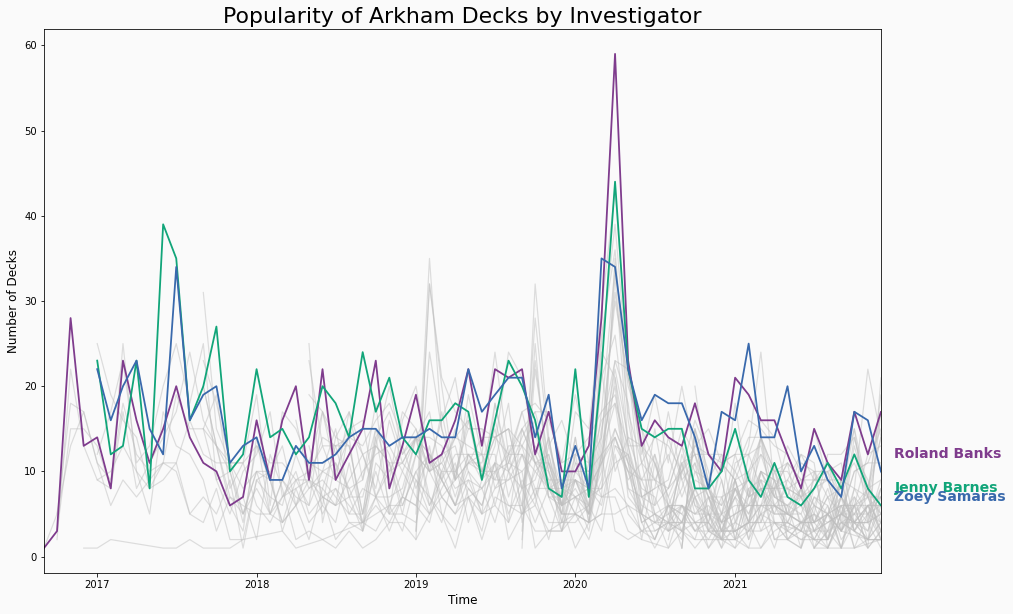

In [50]:
# Initialize layout
fig, ax = plt.subplots(figsize = (15, 10))

# Background color
fig.patch.set_facecolor(GREY98)
ax.set_facecolor(GREY98)

# Decide about adding in these reference lines ------------------
# Vertical lines used as scale reference:
#for h in VLINES:
#    ax.axvline(h, color=GREY91, lw=0.6, zorder=0)

# Horizontal lines
#ax.hlines(y=np.arange(-4, 4), xmin=2016, xmax=2021, color=GREY91, lw=0.6)

# Darker horizontal line at y=0
#ax.hlines(y=0, xmin=2016, xmax=2021, color=GREY60, lw=0.8)

# Vertical like at x = 2008
#ax.axvline(2018, color=GREY40, ls="dotted")

# Annotations indicating the meaning of the vertical line
#ax.text(2018.15, -3.35, "2018", fontname="Montserrat", 
#        fontsize=14, fontweight=500, color=GREY40, ha="left")

# Add plot lines ------------------------------------------------------
# Create one data frame for the highlighted values, and other for non-highlighted
df_highlight = df_ts[df_ts["group"] != "other"]
df_others = df_ts[df_ts["group"] == "other"]

for group in df_others["investigator_name"].unique():
    data = df_others[df_others["investigator_name"] == group]
    ax.plot("date", "count", c=GREY75, lw=1.2, alpha=0.5, data=data)

for idx, group in enumerate(df_highlight["investigator_name"].unique()):
    data = df_highlight[df_highlight["investigator_name"] == group]
    color = COLOR_SCALE[idx]
    ax.plot("date", "count", color=color, lw=1.8, data=data)

# Set datetime boundaries for the x-axis, with extra padding at the end for labels
ax.set_xlim([datetime(2016, 9, 1), datetime(2021, 12, 1)])

# Add labels ----------------------------------------------------------

ax.set_ylabel('Number of Decks', fontsize = 12)
ax.set_xlabel('Time', fontsize = 12)
ax.set_title('Popularity of Arkham Decks by Investigator', fontsize = 22)


# x-axis label positioning
x_end = datetime(2022,1,1)
PAD = 0.1

# Add labels for highlighted countries only
for idx, group in enumerate(df_highlight["investigator_name"].unique()):
    data = df_highlight[(df_highlight["investigator_name"] == group)]
    color = COLOR_SCALE[idx]
    
    # Investigator name
    text = data["investigator_name"].values[0]
    
    # Vertical label placement
    y_end = data["count"].values[-1]    # Return last value for count to line up label

    
    # Add name
    ax.text(
        x_end, 
        y_end, 
        text, 
        color=color, 
        fontsize=14, 
        weight="bold", 
        va="center"
    )

In [51]:
data["count"].values[-1]

7

## Create Racing Bar Chart

Updates:
- **Racing Bar Chart is now created seperately**. Older versions of custom racing bar are commented out below
- Make df with only the rolling sums
- Make col names of this new df just investigator names
- decide on if 30 day sums are best measure

In [52]:
### OLD: chart with daily period
#bcr.bar_chart_race(
#    df=df_wide_sums[1500:1550],
#    filename=None,
#    orientation='h',
#    sort='desc',
#    n_bars=10,
#    fixed_order=False,
#    fixed_max=True,
#    steps_per_period=10,
#    interpolate_period=False,
#    label_bars=True,
#     bar_size=.95,
#    #period_label={'x': .99, 'y': .25, 'ha': 'right', 'va': 'center'},
#    period_fmt='%B %d, %Y',
#    #period_summary_func=lambda v, r: {'x': .99, 'y': .18,
#    #                                  's': f'Total deaths: {v.nlargest(6).sum():,.0f}',
#    #                                  'ha': 'right', 'size': 8, 'family': 'Courier New'},
#    #perpendicular_bar_func='median',
#    period_length=200,
#    figsize=(5, 3),
#    dpi=144,
#    cmap='dark12',
#    title='Investigator Popularity',
#    title_size='',
#    bar_label_size=7,
#    tick_label_size=7,
#    shared_fontdict={'family' : 'Helvetica', 'color' : '.1'},
#    scale='linear',
#    writer=None,
#    fig=None,
#    bar_kwargs={'alpha': .7},
#    filter_column_colors=False)

In [53]:
# Example from documentation

#bcr.bar_chart_race(
#    df=df_wide,
#    filename='covid19_horiz.mp4',
#    orientation='h',
#    sort='desc',
#    n_bars=6,
#    fixed_order=False,
#    fixed_max=True,
#    steps_per_period=10,
#    interpolate_period=False,
#    label_bars=True,
#    bar_size=.95,
#    period_label={'x': .99, 'y': .25, 'ha': 'right', 'va': 'center'},
#    period_fmt='%B %d, %Y',
#    period_summary_func=lambda v, r: {'x': .99, 'y': .18,
#                                      's': f'Total deaths: {v.nlargest(6).sum():,.0f}',
#                                      'ha': 'right', 'size': 8, 'family': 'Courier New'},
#    perpendicular_bar_func='median',
#    period_length=500,
#    figsize=(5, 3),
#    dpi=144,
#    cmap='dark12',
#    title='COVID-19 Deaths by Country',
#    title_size='',
#    bar_label_size=7,
#    tick_label_size=7,
#    shared_fontdict={'family' : 'Helvetica', 'color' : '.1'},
#    scale='linear',
#    writer=None,
#    fig=None,
#    bar_kwargs={'alpha': .7},
#    filter_column_colors=False)